In [33]:
import pickle
import numpy as np

# Current version: 2024
with open("./results/params_search_PPO_solid.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

# 2023 version (Q is not considerable)
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1)) == 1)
print("indices : ", indices[0])

indices :  [ 3132  4557  5458 ... 99674 99680 99865]


In [40]:
# 2024 version: check the cases where Q is higher
Qs = np.array([comp['Q'] for comp in result['state']])
indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1) * (Qs > 10.0)) == 1)
print("indices : ", indices[0])

indices :  [22380 23174 26891 ... 97966 98431 99038]


In [41]:
# best reward case
reward = np.array([result['reward'][idx] for idx in indices[0]])

arg_max = np.argmax(reward)
arg_max = indices[0][arg_max]

for key in result['state'][arg_max].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_max][key]))
    
for key in result['control'][arg_max].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_max][key]))

R : 5.870
a : 1.677
blanket_thickness : 1.164
coil_thickness : 1.358
n : 1.202
TBR : 1.763
beta : 2.552
tau : 1.097
Ip : 12.322
q : 3.700
li : 429.485
f_BS : 0.226
Q_parallel : 824.004
n_g : 1.394
q_kink : 2.000
beta_troyon : 3.560
f_NC : 1.047
n_tau : 1.319
n_tau_lower : 2.094
cost : 0.999
Q : 11.676
betan : 4.000
k : 1.900
epsilon : 3.500
electric_power : 1500000000.000
T_avg : 15.000
B0 : 16.000
H : 1.300
armour_thickness : 0.050
RF_recirculating_rate : 0.200


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


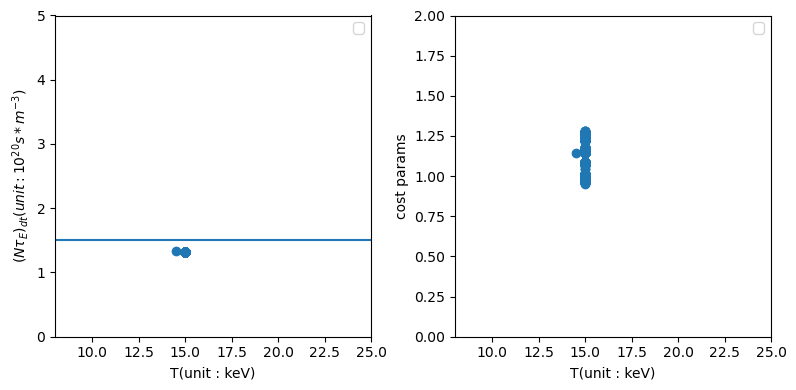

In [42]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [43]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 4.162
a : 1.189
blanket_thickness : 1.164
coil_thickness : 1.382
n : 1.427
TBR : 2.017
beta : 4.273
tau : 0.924
Ip : 12.111
q : 2.248
li : 0.021
f_BS : 0.640
Q_parallel : 492.053
n_g : 2.726
q_kink : 2.000
beta_troyon : 5.859
f_NC : 0.647
n_tau : 1.319
n_tau_lower : 2.081
cost : 0.954
Q : 11.802
betan : 4.000
k : 1.900
epsilon : 3.500
electric_power : 754028137.207
T_avg : 15.000
B0 : 16.000
H : 1.300
armour_thickness : 0.050
RF_recirculating_rate : 0.200


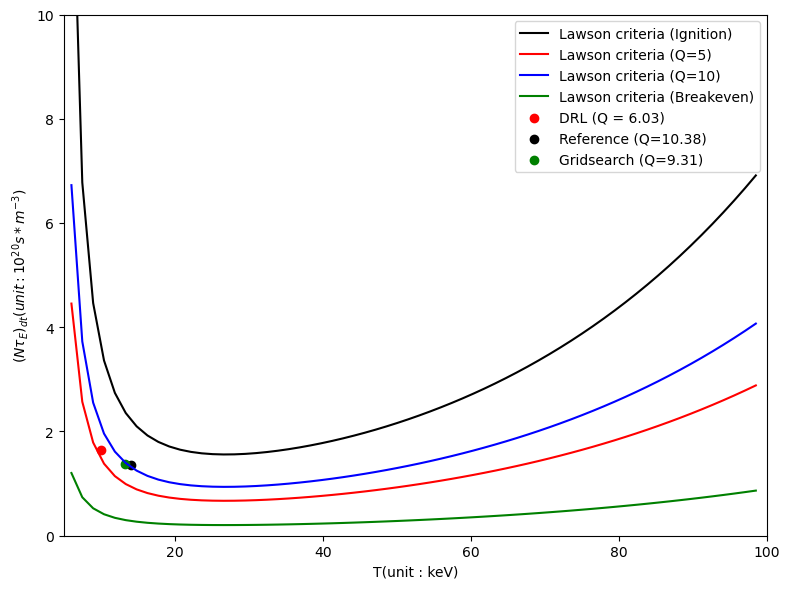

In [9]:
# Optimized case
tau_operation = result['state'][arg_min]['tau']
T_operation = result['control'][arg_min]['T_avg']
Q_operation = 6.03

# Reference case
Q_reference = 10.38
n_reference = 1.43
tau_reference = 0.944
T_reference = 14

# Gridsearch case
Q_gridsearch = 9.31
n_gridsearch = 1.64
tau_gridsearch = 0.840
T_gridsearch = 13.2

# Lawson curve
n_tau = result['state'][arg_min]['n_tau']
n_tau_T = T * n_tau

T = np.linspace(6, 100, 64, endpoint=False)
n = result['state'][arg_min]['n'] * 10 ** 20
B = result['control'][arg_min]['B0'] * (1 - (result['state'][arg_min]['a'] + result['state'][arg_min]['blanket_thickness'])/result['state'][arg_min]['R'])

psi = 10 ** (-3)

Q = 10

n_tau = [lawson.compute_n_tau_lower_bound(t, n, B, psi) * 10 ** (-20) for t in T]
n_tau_5 = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 5) * 10 ** (-20) for t in T]
n_tau_Q = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, Q) * 10 ** (-20) for t in T]
n_tau_break = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 1) * 10 ** (-20) for t in T]
n *= 10 ** (-20)
        
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(T, n_tau, "k", label = "Lawson criteria (Ignition)")
ax.plot(T, n_tau_5, "r", label = "Lawson criteria (Q=5)")
ax.plot(T, n_tau_Q, "b", label = "Lawson criteria (Q={})".format(Q))
ax.plot(T, n_tau_break, "g", label = "Lawson criteria (Breakeven)")
ax.scatter(T_operation, tau_operation * n, c = 'r', label = 'DRL (Q = {:.2f})'.format(Q_operation))
ax.scatter(T_reference, tau_reference * n_reference, c = 'k', label = 'Reference (Q={:.2f})'.format(Q_reference))
ax.scatter(T_gridsearch, tau_gridsearch * n_gridsearch, c = 'g', label = 'Gridsearch (Q={:.2f})'.format(Q_gridsearch))

ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.set_xlim([5,100])
ax.set_ylim([0,10])
ax.legend()
fig.tight_layout()

plt.savefig("./results/lawson_comparison.png")

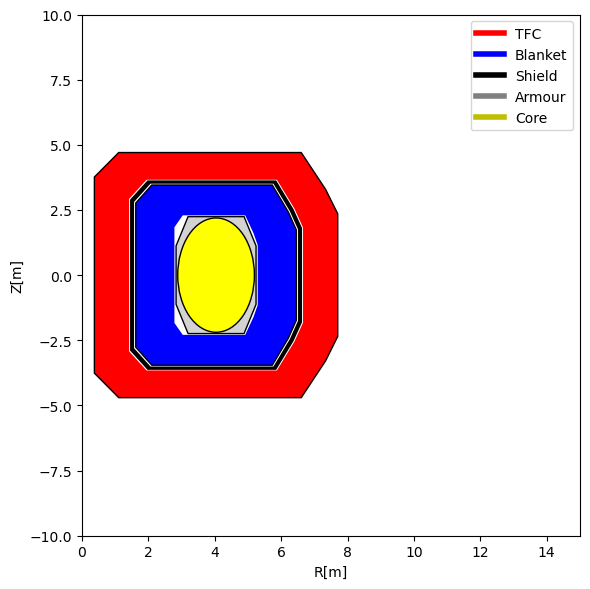

In [11]:
from src.plot import plot_design_poloidal

fig, ax = plot_design_poloidal(
    result['state'][arg_min]['R'],
    result['state'][arg_min]['a'],
    result['state'][arg_min]['a'] * result['control'][arg_min]['k'],
    result['control'][arg_min]['armour_thickness'],
    result['state'][arg_min]['blanket_thickness'],
    result['state'][arg_min]['coil_thickness'],
    0.1,
    0,
    15,
    -10,
    +10
)

fig.tight_layout()

### PPO without cost reward

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


indices :  [2724 5155 5226 5444 7483 7549 7688 7786 7902 8244 8434 8878 9019 9365
 9565 9782 9785 9915 9990]


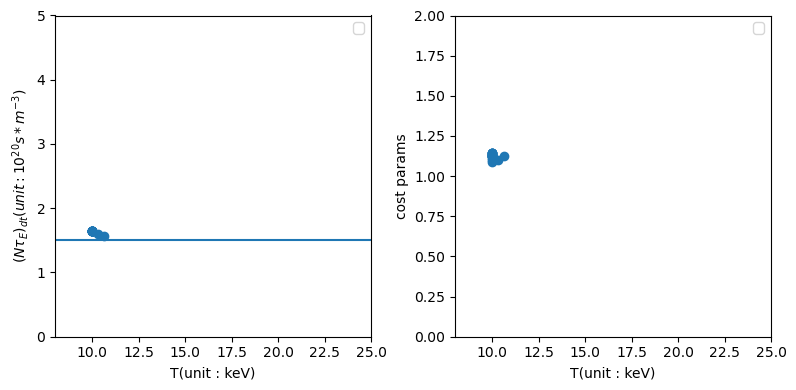

In [12]:
import pickle
import numpy as np

with open("./results/params_search_PPO_solid_wo-cost.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

indices = np.where(((b_limit == 1) * (n_limit == 1) * (q_limit == 1) * (f_limit == 1) * (tbr >= 1)) == 1)
print("indices : ", indices[0])

# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [13]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 3.849
a : 0.855
blanket_thickness : 1.164
coil_thickness : 1.197
n : 2.298
TBR : 2.358
beta : 4.508
tau : 0.713
Ip : 7.561
q : 2.032
f_BS : 0.794
Q_parallel : 357.018
n_g : 3.289
q_kink : 2.000
beta_troyon : 5.041
f_NC : 0.813
n_tau : 1.639
n_tau_lower : 3.604
cost : 1.086
betan : 4.000
k : 1.900
epsilon : 4.500
electric_power : 501606842.041
T_avg : 10.000
B0 : 14.755
H : 1.300
armour_thickness : 0.050
RF_recirculating_rate : 0.200


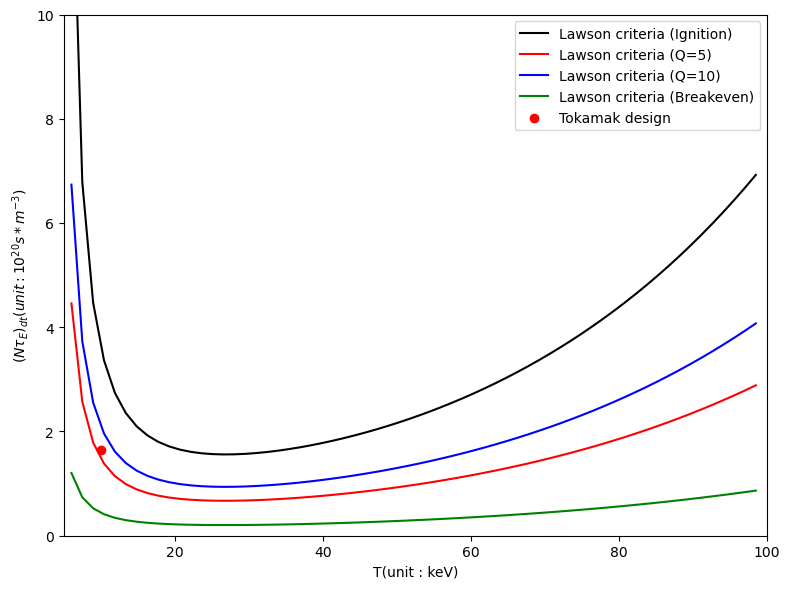

In [14]:
# Lawson curve
tau_operation = result['state'][arg_min]['tau']
T_operation = result['control'][arg_min]['T_avg']

n_tau = result['state'][arg_min]['n_tau']
n_tau_T = T * n_tau

T = np.linspace(6, 100, 64, endpoint=False)
n = result['state'][arg_min]['n'] * 10 ** 20
B = result['control'][arg_min]['B0'] * (1 - (result['state'][arg_min]['a'] + result['state'][arg_min]['blanket_thickness'])/result['state'][arg_min]['R'])

psi = 10 ** (-3)

Q = 10

n_tau = [lawson.compute_n_tau_lower_bound(t, n, B, psi) * 10 ** (-20) for t in T]
n_tau_5 = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 5) * 10 ** (-20) for t in T]
n_tau_Q = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, Q) * 10 ** (-20) for t in T]
n_tau_break = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 1) * 10 ** (-20) for t in T]
n *= 10 ** (-20)
        
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(T, n_tau, "k", label = "Lawson criteria (Ignition)")
ax.plot(T, n_tau_5, "r", label = "Lawson criteria (Q=5)")
ax.plot(T, n_tau_Q, "b", label = "Lawson criteria (Q={})".format(Q))
ax.plot(T, n_tau_break, "g", label = "Lawson criteria (Breakeven)")
ax.scatter(T_operation, tau_operation * n, c = 'r', label = 'Tokamak design')

ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.set_xlim([5,100])
ax.set_ylim([0,10])
ax.legend()
fig.tight_layout()

### Gridsearch case

In [1]:
import pickle
import numpy as np

with open("./results/params_search_gridsearch_solid.pkl", 'rb') as f:
    result = pickle.load(f)
    
tau = [comp['tau'] for comp in result['state']]
b_limit = result['beta_limit']
q_limit = result['q_limit']
n_limit = result['n_limit']
f_limit = result['f_limit']
i_limit = result['i_limit']
tbr = np.array([result['state'][idx]['TBR'] for idx in range(len(tau))])
T = np.array([result['control'][idx]['T_avg'] for idx in range(len(tau))])

tau = np.array(tau)
b_limit = np.array(b_limit)
q_limit = np.array(q_limit)
n_limit = np.array(n_limit)
f_limit = np.array(f_limit)
i_limit = np.array(i_limit)

indices = np.where(((b_limit == 1) * (q_limit == 1) * (n_limit == 1) * (f_limit == 1) * (tbr >= 1) * (tbr < 2)) == 1)
print("indices : ", indices[0])
print("# of cases : {}".format(len(indices[0])))

indices :  [  31   32   34 ... 9968 9969 9970]
# of cases : 1220


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


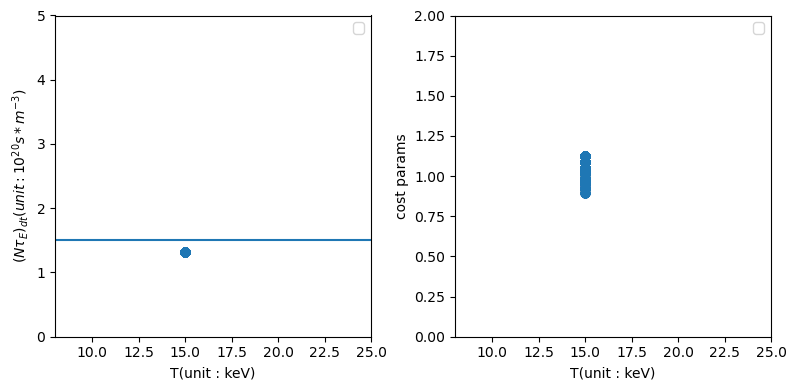

In [2]:
# n*tau*T graph
from src.lawson import Lawson
import matplotlib.pyplot as plt

lawson = Lawson()

# Lawson-criteria
T = np.array([result['control'][idx]['T_avg'] for idx in indices[0]])
n_tau = np.array([result['state'][idx]['n_tau'] for idx in indices[0]])
n_tau_T = T * n_tau

# Cost paramter
cost = np.array([result['state'][idx]['cost'] for idx in indices[0]])

fig, axes = plt.subplots(1,2,figsize = (8,4))
axes = axes.ravel()
ax = axes[0]
ax.scatter(T, n_tau)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.axhline(1.5, 0, 1)
ax.set_xlim([8,25])
ax.set_ylim([0,5])
ax.legend()

ax = axes[1]
ax.scatter(T, cost)
ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("cost params")
ax.set_xlim([8,25])
ax.set_ylim([0,2])
ax.legend()

fig.tight_layout()

In [3]:
arg_min = np.argmin(cost)
arg_min = indices[0][arg_min]

for key in result['state'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['state'][arg_min][key]))
    
for key in result['control'][arg_min].keys():
    print("{} : {:.3f}".format(key, result['control'][arg_min][key]))
    

R : 6.550
a : 1.531
blanket_thickness : 1.164
coil_thickness : 0.775
n : 1.261
TBR : 1.822
beta : 4.103
tau : 1.046
Ip : 12.598
q : 2.105
f_BS : 0.503
Q_parallel : 596.636
n_g : 1.711
q_kink : 2.000
beta_troyon : 4.112
f_NC : 0.769
n_tau : 1.319
n_tau_lower : 2.082
cost : 0.892
betan : 3.333
k : 1.856
epsilon : 4.278
electric_power : 1500000000.000
T_avg : 15.000
B0 : 11.333
H : 1.133
armour_thickness : 0.050
RF_recirculating_rate : 0.189


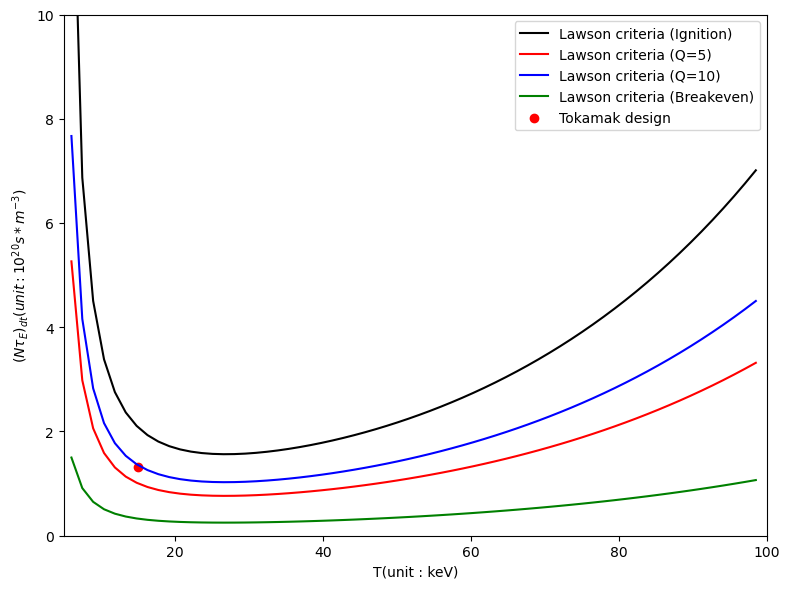

In [4]:
# Lawson curve
tau_operation = result['state'][arg_min]['tau']
T_operation = result['control'][arg_min]['T_avg']

n_tau = result['state'][arg_min]['n_tau']
n_tau_T = T * n_tau

T = np.linspace(6, 100, 64, endpoint=False)
n = result['state'][arg_min]['n'] * 10 ** 20
B = result['control'][arg_min]['B0'] * (1 - (result['state'][arg_min]['a'] + result['state'][arg_min]['blanket_thickness'])/result['state'][arg_min]['R'])

psi = 10 ** (-3)

Q = 10

n_tau = [lawson.compute_n_tau_lower_bound(t, n, B, psi) * 10 ** (-20) for t in T]
n_tau_5 = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 5) * 10 ** (-20) for t in T]
n_tau_Q = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, Q) * 10 ** (-20) for t in T]
n_tau_break = [lawson.compute_n_tau_Q_lower_bound(t, n, B, psi, 1) * 10 ** (-20) for t in T]
n *= 10 ** (-20)
        
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(T, n_tau, "k", label = "Lawson criteria (Ignition)")
ax.plot(T, n_tau_5, "r", label = "Lawson criteria (Q=5)")
ax.plot(T, n_tau_Q, "b", label = "Lawson criteria (Q={})".format(Q))
ax.plot(T, n_tau_break, "g", label = "Lawson criteria (Breakeven)")
ax.scatter(T_operation, tau_operation * n, c = 'r', label = 'Tokamak design')

ax.set_xlabel("T(unit : keV)")
ax.set_ylabel("$(N\\tau_E)_{dt}(unit:10^{20}s * m^{-3})$")
ax.set_xlim([5,100])
ax.set_ylim([0,10])
ax.legend()
fig.tight_layout()

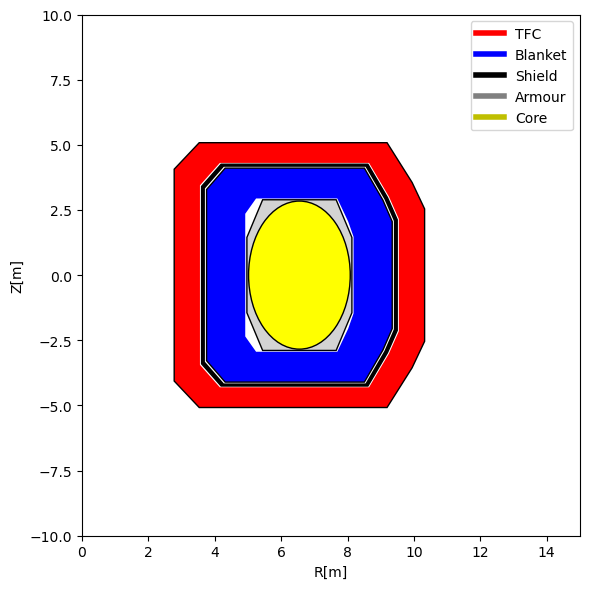

In [18]:
from src.plot import plot_design_poloidal

fig, ax = plot_design_poloidal(
    result['state'][arg_min]['R'],
    result['state'][arg_min]['a'],
    result['state'][arg_min]['a'] * result['control'][arg_min]['k'],
    result['control'][arg_min]['armour_thickness'],
    result['state'][arg_min]['blanket_thickness'],
    result['state'][arg_min]['coil_thickness'],
    0.1,
    0,
    15,
    -10,
    +10
)

fig.tight_layout()

### Reward shape engineering

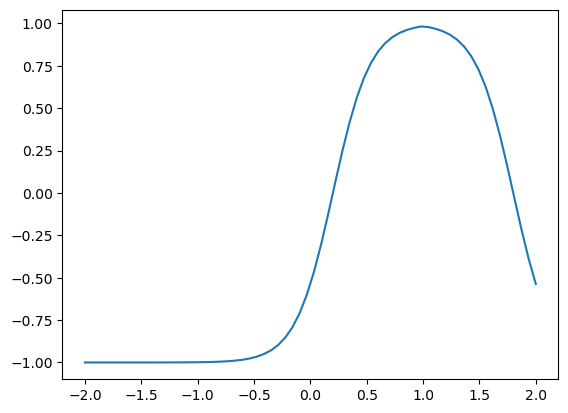

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def compute_sigmoid(x):
    return math.tanh(x)

def reward_func(x, scale, a, x_min, x_max):
    xn = x / scale
    xnl = x_min / scale
    xrl = x_max / scale
    
    if xn < xrl:
        reward = compute_sigmoid(a * (xn - xnl))
    else:
        reward = compute_sigmoid(a * (2 * xrl - xnl - xn))
        
    return reward

x = np.linspace(-2,2,64)
y = np.array([reward_func(t, 1, 3, 0.2, 1.0) for t in x])

plt.plot(x,y)

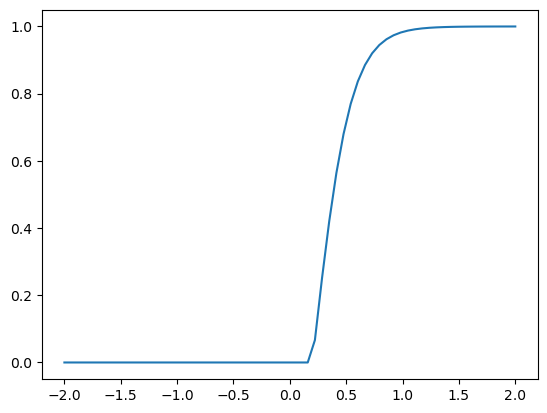

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def compute_sigmoid(x):
    return math.tanh(x)

def reward_func(x, scale, a, x_min, x_max):
    xn = x / scale
    xnl = x_min / scale
    xrl = x_max / scale
    
    if xn > xnl:
        reward = compute_sigmoid(a * (xn - xnl))
    else:
        reward = 0
        
    return reward

x = np.linspace(-2,2,64)
y = np.array([reward_func(t, 1, 3, 0.2, 1.0) for t in x])

plt.plot(x,y)

In [2]:
import pickle
import numpy as np

with open("./results/params_search_gridsearch_solid.pkl", 'rb') as f:
    gridsearch = pickle.load(f)
    
with open("./results/params_search_PPO_solid.pkl", 'rb') as f:
    ppo = pickle.load(f)

In [3]:
total_reward_ppo = ppo['reward']
total_reward_gridserach = sorted(gridsearch['reward'])
total_reward_gridserach = gridsearch['reward']

episodes = np.array([i + 1 for i in range(len(total_reward_ppo))])

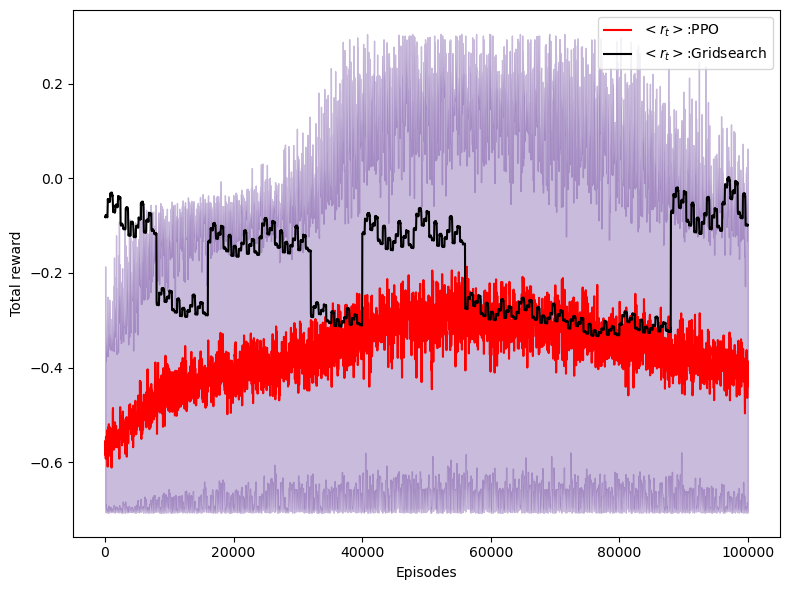

In [4]:
import matplotlib.pyplot as plt
import os
from src.utility import temperal_average

temporal_length = 32

x_mean, ppo_reward_mean, ppo_reward_lower, ppo_reward_upper = temperal_average(episodes, total_reward_ppo, temporal_length)
_, gridsearch_reward_mean, _, _ = temperal_average(episodes, total_reward_gridserach, temporal_length)

fig = plt.figure(figsize = (8,6))
clr = plt.cm.Purples(0.9)

plt.plot(x_mean, ppo_reward_mean, c = 'r', label = '$<r_t>$:PPO')
plt.plot(x_mean, gridsearch_reward_mean, c = 'k', label = '$<r_t>$:Gridsearch')
plt.fill_between(x_mean, ppo_reward_lower, ppo_reward_upper, alpha = 0.3, edgecolor = clr, facecolor = clr)
        
plt.xlabel("Episodes")
plt.ylabel("Total reward")
plt.legend(loc = 'upper right')

fig.tight_layout()
plt.savefig(os.path.join("./results", "reward_comparsion.png"), facecolor = fig.get_facecolor(), edgecolor = 'none', transparent = False)